# PHYS 164 - Fall 2019 - Coding Exercise 4
### Finding Stars, Centroids and querying a catalog

## Problem Statement

Complete this Jupyter Notebook by filling in code and explanations where indicated. Broadly, the steps that you will be performing in this coding Exercise are:
1. Loading FITS Files from the given data and performing data reduction
2. Writing code to algorithmically identify stars in the field
3. Calculate the Centroids of the PSFs of all the identified stars (along with uncertainty)
4. Retrieving Star Positions from USNO-B1 Catalog for the field using VizieR
5. Converting to Standard Coordinates and plotting star positions.

At this stage you may assume the plate to be "ideal", i.e. subject to translation and magnification only according to the formulae in the notes.

Be sure to follow the instructions given in this notebook and pay attention to `TODO` sprinkled throughout the notebook. Points are assigned to most cells and the whole notebook will be manually graded.

*Remember to Save the notebook, then select **Kernel $\rightarrow$ Restart & Run All** before you submit*.

Make sure you have replaced all lines of code which read:

`# YOUR CODE HERE
raise NotImplementedError()`

## 1. Loading the FITS Files and Data Reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

In [2]:
data_dir = '/datasets/phys164-fa19-public/lab3_sample_data/'
data_files = np.array(sorted(os.listdir(data_dir)))

In [3]:
def load_headers_all_files(headers):
    """ Reads and returns multiple FITS headers from all files.
    Relies on global variables data_dir and data_files """
    
    # All loaded headers will be saved here. np.full() creates a NumPy array of a given shape (first argument)
    # filled with a constant value (second argument, empty string in this case). "dtype = object" will allow
    # the array to store data of any type (some headers may be numbers, not strings).
    output = np.full([len(headers), len(data_files)], "", dtype = object)
    
    # Now read the headers from all files
    
    for y in range(len(headers)):
        for x in range(len(data_files)):
            hdu = fits.open(data_dir + data_files[x])
            output[y][x] = hdu[0].header[headers[y]]
            hdu.close()
    
    return output

In [4]:
# Test drive the function
import pandas
headers = ['OBSTYPE', 'OBJECT', 'EXPTIME', 'FILTNAM', 'COVER']
obstypes, objects, exptimes, filters, overscans = load_headers_all_files(headers) # Calling the defined function here
headers_lists = list(zip(obstypes, objects, exptimes, filters, overscans))
fits_dataframe1=pandas.DataFrame(headers_lists, columns=headers)
fits_dataframe1

,OBSTYPE,OBJECT,EXPTIME,FILTNAM,COVER
0,OBJECT,flat,4.0,B,32
1,OBJECT,flat,9.0,V,32
2,OBJECT,flat,12.0,R,32
3,OBJECT,flat,40.0,I,32
4,OBJECT,109_954,40.0,B,32
5,OBJECT,109_954,20.0,V,32
6,OBJECT,109_954,10.0,R,32
7,OBJECT,109_954,10.0,I,32
8,OBJECT,PSN22+40,180.0,B,32
9,OBJECT,PSN22+40,150.0,V,32


### Data Reduction

In [5]:
first_flat = data_files[objects == 'flat'][0]

def load_frame_overscan_remove_bias_subtract(filename):
    """ Find bias by taking average of rows of overscan and then subtracts the bias from the trimmed flat. 
    Uses data_dir and assumes the overscan is in extra columns and the final image is square."""
    
    hdu = fits.open(data_dir + filename)
    naxis1 = hdu[0].header['NAXIS1'] #finds number of columns
    OSregion = hdu[0].header['COVER'] #finds how many columns are overscan
    dimension = naxis1 - OSregion
    temp = np.array(hdu[0].data)
    overscan = temp[0:len(temp),dimension:naxis1]
    test_flat = temp[0:len(temp),0:dimension] #trim

    avg_rows_overscan = np.zeros(len(overscan))
    for i,y in enumerate(overscan):
        avg_rows_overscan[i] = np.average(y)

    #set each row of bias equal to row average of overscan
    bias = np.array([avg_rows_overscan for y in range(dimension)]) 
    bias = np.transpose(bias)

    image = test_flat - bias
    hdu.close()
    
    return image

In [6]:
def plot_fits_im(ax, data, xlabel='x (px)', ylabel='y (px)', title='', **imshow_kwargs):
    ax.imshow(data, **imshow_kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

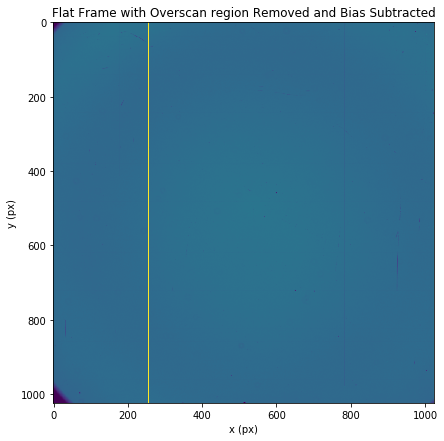

In [7]:
data = load_frame_overscan_remove_bias_subtract(first_flat)
fig1, ax1 = plt.subplots(figsize = [7, 7])
plot_fits_im(ax1, data, title='Flat Frame with Overscan region Removed and Bias Subtracted')
fig1.show()

In [8]:
def load_reduced_science_frame(filename):
    """
    Loads a Science frame specified by the FITS file name,
    performs reduction through bias subtraction and normalized
    flat field correction and returns the data
    """
    
    hdu = fits.open(data_dir + filename)
    naxis1 = hdu[0].header['NAXIS1'] #finds number of columns
    OSregion = hdu[0].header['COVER'] #finds how many columns are overscan
    filter_name = hdu[0].header['FILTNAM']
    dimension = naxis1 - OSregion
    temp = np.array(hdu[0].data)
    overscan = temp[0:len(temp),dimension:naxis1]
    science = temp[0:len(temp),0:dimension] #trim

    avg_rows_overscan = np.zeros(len(overscan))
    for i,y in enumerate(overscan):
        avg_rows_overscan[i] = np.average(y)

    #set each row of bias equal to row average of overscan
    bias = np.array([avg_rows_overscan for y in range(dimension)]) 
    bias = np.transpose(bias)

    image = science - bias
    hdu.close()
    
    #find flat image of same filter as science image
    flat_file = [data_files[i] for i in range(len(data_files)) if data_files[i] in data_files[objects == 'flat']\
             and data_files[i] in data_files[filters == filter_name]][0]
    
    #process flat
    flat = load_frame_overscan_remove_bias_subtract(flat_file)

    #normalize flat by median
    data_median = np.median(flat)
    flat_norm = flat/data_median

    data = image/flat_norm
    
    return data

In [9]:
# Specify the Science Frame you wish to examine

science_frame = 'd160.fits'

# YOUR CODE HERE
#Do I really need code here?

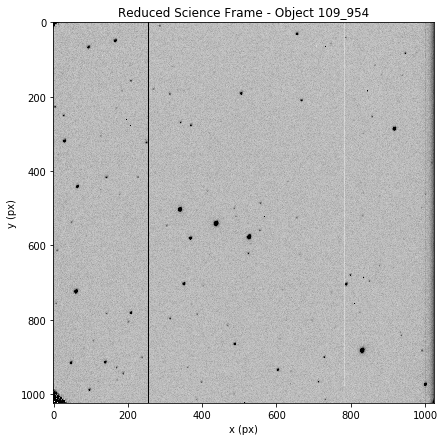

In [10]:
science_data = load_reduced_science_frame(science_frame)

fig2, ax2 = plt.subplots(figsize = [7, 7])
plot_fits_im(ax2, science_data,
             title='Reduced Science Frame - Object {}'.format(objects[data_files == science_frame][0]),
             vmax = np.median(science_data) * 3, cmap = "Greys")
fig2.show()

## 2. Automatically Identifying Stars

In [11]:
def find_star_locs(im_data, n_size = 10, bright_count_thresh=10):
    """
    ARGUMENTS:
    ================================================================
    im_data - Reduced 2D FITS Data
    n_size  - Neighborhood size to consider for windowing (pixels)
    bright_count_thresh - Threshold for number of 'bright'pixels in
                          neighborhood to be considered a star.
                          (Proportional to size of Star blob)
    RETURNS:
    ================================================================
    [[x_positions_of_star_center, x_positions_of_star_center]]
    i.e., a list of list of x and y coordinate of star centers
    """
    
    x = range(len(im_data[0]))
    y = range(len(im_data))
    z = im_data
    peak_point_rows = []
    peak_point_cols = []
    list_pos = []
    thresh = np.median(im_data)*2
    
    j = 3
    
    #test per row where peaks are by checking neighbors
    while j < len(y)-3:
        i = 3
        while i < len(x)-3:
            if z[j][i] > thresh:
                if z[j][i-3] < z[j][i-2] and z[j][i-2] < z[j][i-1] and z[j][i-1] < z[j][i] \
                and z[j][i] > z[j][i+1] and z[j][i+1] > z[j][i+2] and z[j][i+2] > z[j][i+3]:
                    peak_point_rows.append([i,j])
            
            i = i + 1
        j = j + 1
        
    #Do the same for columns
    i = 3
    while i < len(x)-3:
        j = 3
        while j < len(y)-3:
            if z[j][i] > thresh:
                if z[j-3][i] < z[j-2][i] and z[j-2][i] < z[j-1][i] and z[j-1][i] < z[j][i] \
                and z[j][i] > z[j+1][i] and z[j+1][i] > z[j+2][i] and z[j+2][i] > z[j+3][i]:
                    peak_point_cols.append([i,j])

            j = j + 1
        i = i + 1
        
    #compare lists of peaks and if they are equal and have a minimum number of bright points in the region 
    #then they get assigned the the peak points
    for a in peak_point_rows:
        for b in peak_point_cols:
            if a == b:
                temp = z[a[1]-round(n_size/2):a[1]+round(n_size/2),a[0]-round(n_size/2):a[0]+round(n_size/2)]
                temp.flatten()
                brights = np.where(temp > thresh)[0]
                if len(brights) >= bright_count_thresh:
                    list_pos.append(a)
    
    return list_pos

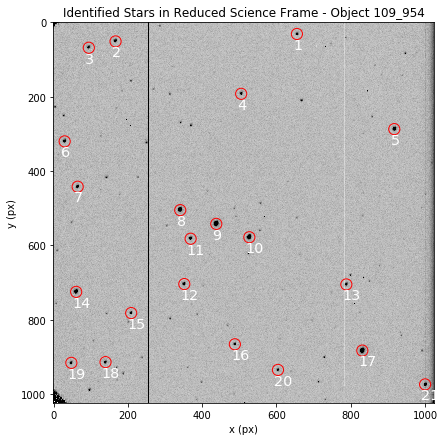

In [12]:
ident_star_locs = find_star_locs(science_data, bright_count_thresh=30)

import matplotlib.patches as patches
fig3, ax3 = plt.subplots(figsize = [7, 7])
plot_fits_im(ax3, science_data,
             title='Identified Stars in Reduced Science Frame - Object {}'.format(objects[data_files == science_frame][0]),
             vmax = np.median(science_data) * 3, cmap = "Greys")

# Write code that will plot Circles at each of the identified star locations
# Also label each identified star, starting from 1

points = ident_star_locs
for i in range(len(points)):
    plt.text(points[i][0]-10,points[i][1]+40,str(i+1),size='x-large',c='white',ma='center')
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(plt.Circle((points[i][0], points[i][1]), 15, color='r',fill=False))
    
fig3.show()

## 3. Calculating centroids of identified stars

We will calculate the centroid of the identified stars, by using the following formula (see next cell) on all the pixels in a rectangular window. The rectangular window size will be calculated as the FWHM that we will calculate for each star in the x and y directions. We will implement finding centroids as a standalone function, which takes in the Intensity and Position 2D-arrays with our CCD data along with the list of (x,y) of identified stars and returns the list of centroids with uncertainities for all identified stars.

**Note:** If the identified star location is too close to the edge of the field, we will ignore these and return **NaN** as the value for all four, i.e., `[NaN, NaN, NaN, NaN]` for each such star

### Formulae for Calculating Centroids (with Error)

YOUR ANSWER HERE
$$\langle p \rangle = \frac{\sum p_i I_i}{\sum I_i}$$
$$\sigma_{\langle p \rangle} = \frac{\sum I_i(x_i-<x>)^2}{(\sum I_i)^2}$$

where, $p \in {x, y}$ is the position coordinate and $I_p$ is the intensity at position $p$.

In [13]:
# Creating Position Array that is same dimension as the image we're working with
row_dim = np.shape(science_data)[0]
row_pos = np.array(range(row_dim))[np.newaxis]
pos_xarr = np.tile(row_pos.T, (1 ,row_dim))
pos_yarr = np.tile(row_pos  , (row_dim,1 ))
pos_arr = np.dstack((pos_xarr, pos_yarr))

In [14]:
def calc_centroids_2d(intarr, posarr, loc_list, window_max = 20):
    """
    Estimates centroids of stars based on their given pixel locations. Provides the centroids as well as 
    their error
    
    PARAMETERS:
    ==================================================================================
    intarr - data from image
    posarr - Not used because it's redundant
    loc_list - list of pixel location in stars in format (x,y)
    window_max - Size of Window to consider to find max pos of each star (in pixels)
    
    RETURNS:
    ==================================================================================
    centroids - List of list of centroid coordinates and corresponding uncertainities
                Format: [[xc, yc, unc_xc, unc_yc]]
    """
    
    centroids = [] # Append Tuples (xc, yc, xc_err, yc_err) of centroid coordinates
                   # No. of tuples should equal length of loc_list
    
    x = range(len(intarr[0]))
    y = range(len(intarr))
    z = intarr
    
    window = window_max
    
    for locx,locy in loc_list:
        xmin = int(locx) - int(window/2)
        xmax = int(locx) + int(window/2)
        x_px = range(xmin,xmax)
        x_values = z[locy][x_px]
        centroidx = np.sum(x_px*x_values)/np.sum(x_values)
        xc_err = np.sum(x_values*(x_px - centroidx)**2)/np.sum(x_values**2)
        
        ymin = int(locy) - int(window/2)
        ymax = int(locy) + int(window/2)
        y_px = range(ymin,ymax)
        y_values = z[ymin:ymax,locx]
        centroidy = np.sum(y_px*y_values)/np.sum(y_values)
        yc_err = np.sum(y_values*(y_px - centroidy)**2)/np.sum(y_values**2)
        
        centroids.append([centroidx,centroidy,xc_err,yc_err])
    
    return np.array(centroids)

In [15]:
centroids_list = calc_centroids_2d(science_data, pos_arr, ident_star_locs)
centroids_list = np.array(centroids_list) # Convert List of list to 2D array

# Now, we will list the identified X & Y positions of all stars
# and the corresponding centroids calculated

# Points will be awarded for the values obtained

# Headers for the Dataframe
dataframe_header = ['Identified X','Identified Y',
                    'Centroid Xc','Uncertainity Xc','Centroid Yc','Uncertainity Yc']

# Construct a Dataframe for easily viewing the data
centroids_dataframe = pandas.DataFrame(np.hstack((ident_star_locs,centroids_list[:,0:1],
                                                 centroids_list[:,2:3], centroids_list[:,1:2],
                                                 centroids_list[:,3:4])), columns=dataframe_header)
# Display the Pandas Data Frame
centroids_dataframe

,Identified X,Identified Y,Centroid Xc,Uncertainity Xc,Centroid Yc,Uncertainity Yc
0,655.0,31.0,654.793144,0.045539,30.805971,0.045396
1,167.0,51.0,166.567054,0.013576,50.330714,0.016133
2,95.0,68.0,94.810994,0.019175,67.631447,0.021204
3,505.0,192.0,505.042754,0.017931,191.511421,0.020852
4,917.0,287.0,916.983349,0.002780,286.649649,0.003300
5,30.0,320.0,30.085964,0.011860,319.448186,0.013922
6,65.0,442.0,64.990828,0.019815,441.611529,0.022177
7,341.0,505.0,340.826325,0.001326,504.139340,0.001573
8,438.0,542.0,437.721601,0.000718,541.809007,0.000895
9,527.0,578.0,526.381379,0.002087,577.674548,0.002552


## 4. Retrieving Star Positions from USNO-B1 Catalog for field

We will retreive the known star positions from USNO-B1 Catalog (in RA and Dec) for our field. We will use the center RA and Dec of our field to query 

In [16]:
# Imports to query Catalogs

# Simbad queries
from astroquery.simbad import Simbad

# VizieR queries
from astroquery.vizier import Vizier

# Coordinates transformations and units
from astropy.coordinates import SkyCoord
import astropy.units as u

In [17]:
# Write code to find RA and Dec of center of our science frame
# by looking at the header information
science_ra_center = ''
science_dec_center= ''

hdu = fits.open(data_dir + science_frame)
science_ra_center = hdu[0].header['RA']
science_dec_center= hdu[0].header['DEC']
hdu.close()

print("RA  of science frame {}: {} (hr:mins:s)".format(science_frame, science_ra_center ))
print("Dec of science frame {}:{} degrees". format(science_frame, science_dec_center))

RA  of science frame d160.fits: 17:44:50.4 (hr:mins:s)
Dec of science frame d160.fits: 00:05:44.0 degrees


Next, we look at [Aladin](https://aladin.u-strasbg.fr/AladinLite/) and specify the target that we are studying in our Science frame. By mousing over any part of the image, we obtain the actual RA and Dec for that point.

Find the center of your science image in Aladin and read out the actual RA and Dec. Does this match your values obtained from the FITS header? From this consideration, fill out the next cell. We will construct a coordinate object from AstroPy which we will use for querying Vizier.

In [18]:
# Fill the coordinates of the center of your science frame, obtained from Aladin
ra_center = '17:44:13.756'
dec_center = '-00:01:58.37'


# Next, we convert it to a stanadard co-ordinate object from AstroPy, which we can usefor querying
center_coord = SkyCoord(ra = ra_center, dec = dec_center, unit = (u.hour, u.deg), frame='icrs')

In [19]:
# From the start, we tell VizieR that we do not want stars dimmer than 10 Magnitude
# Adjust this limit to match the rough number of stars you're seeing

magnitude_limit = 0.0 # TODO: Set a new value in the lines below
magnitude_limit = 15.0

# Create a VizieR object.
vizier = Vizier(column_filters = {"R2mag" : "<{}".format(magnitude_limit)})

# By default, VizieR will limit the result to 50 stars. We change the limit to "-1" meaning "show everything you have"
# This is a dangerous setting, since some queries may return enormous amounts of data. In our case, however, only a small
# part of the sky is being queried, heavily limited by magnitude. We should be safe.
vizier.ROW_LIMIT = -1

# Run the query. We are requesting the part of the sky defined by the previously created coordinates object (center).
# width, height specify the size of the region we need (in arc minutes).
# Adjust this value to match your science frame
# "catalog = "USNO-B1" tells VizieR which catalogue we want. This could be a list of multiple catalogues.


#11.45
fov_width  = '10.0m' # TODO: Set new values in the lines below
fov_height = '10.0m' # Here, 'm' represents arc minutes



result_table = vizier.query_region(center_coord, width = fov_width, height = fov_height, catalog = "USNO-B1")

print ("Total number of objects retrieved:", len(result_table[0]))
print ("Column names:", result_table[0].keys())

Total number of objects retrieved: 37
Column names: ['USNO-B1.0', 'RAJ2000', 'DEJ2000', 'e_RAJ2000', 'e_DEJ2000', 'Epoch', 'pmRA', 'pmDE', 'Ndet', 'B1mag', 'R1mag', 'B2mag', 'R2mag', 'Imag']


In [20]:
result_table[0]

USNO-B1.0,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,Epoch,pmRA,pmDE,Ndet,B1mag,R1mag,B2mag,R2mag,Imag
,deg,deg,mas,mas,yr,mas / yr,mas / yr,,mag,mag,mag,mag,mag
bytes12,float64,float64,int16,int16,float32,int32,int32,uint8,float32,float32,float32,float32,float32
0899-0311242,265.977248,-0.072325,54,131,1975.7,0,0,5,16.42,14.91,16.01,14.65,14.42
0899-0311306,265.992453,-0.090898,47,73,1975.7,8,2,5,15.63,13.80,15.01,13.46,13.04
0899-0311323,265.997125,-0.019912,78,78,1975.7,12,0,5,16.77,14.70,16.04,14.46,13.97
0899-0311334,265.999278,-0.086312,132,128,1975.7,0,0,5,15.75,14.18,15.28,13.92,13.43
0899-0311366,266.006395,-0.079909,75,57,1975.7,0,0,5,16.27,14.28,15.70,14.10,13.53
0899-0311403,266.017759,-0.009500,36,36,1975.7,0,0,5,16.07,13.60,15.30,13.22,12.54
0899-0311425,266.024175,-0.071292,43,83,1975.7,0,0,5,14.98,11.38,14.04,11.37,10.18
0899-0311446,266.029228,-0.053081,48,78,1975.7,10,10,5,16.44,14.60,15.79,14.49,13.86


Text(0, 0.5, 'DEC (degrees)')

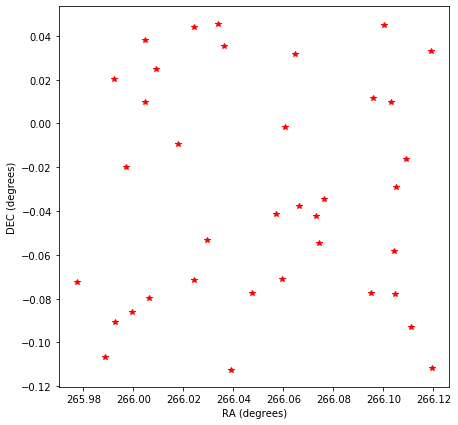

In [21]:
# Extract required data from obtained query results
ra_cat     = np.array(result_table[0]["RAJ2000"])
dec_cat    = np.array(result_table[0]["DEJ2000"])
pm_ra      = np.array(result_table[0]["pmRA"])
pm_dec     = np.array(result_table[0]["pmDE"])
mag        = np.array(result_table[0]["R2mag"])

# Convert result into form we want

epoch = 2013.0   # The science image was taken in 2013. Hence, we will need coordinates in J2017. Strictly speaking
                 # this should be a fractional number, but most stars do not move fast enough to make the difference matter.

# Convert the units of pmDec from mas/yr to deg/yr
pm_dec = pm_dec / 1000.0 / 3600.0

# Same for RA, but with the cos(dec) correction. Note, np.cos() expects radians!
pm_ra  = pm_ra / 1000.0 / 3600.0 / np.cos(dec_cat * np.pi / 180.0)

# Move the stars
ra_cat  += (epoch - 2000.0) * pm_ra
dec_cat += (epoch - 2000.0) * pm_dec

plt.figure(figsize = [7, 7])
plt.plot(ra_cat, dec_cat, 'r*')
plt.xlabel("RA (degrees)")
plt.ylabel("DEC (degrees)")

In [2]:
# Plotting the star position obtained from querying Vizier
# and plotting our obtained centroids on the same plot
fig4 = plt.figure(figsize = [7, 7])
axs = fig4.add_subplot(111, label='science', frame_on=True)
axq = fig4.add_subplot(111, label='Query'  , frame_on=False)

axs.scatter(np.squeeze(centroids_list[:,0:1]), np.squeeze(centroids_list[:,1:2]))
# axs.set_xlim(axs.get_xlim()[::-1])
axs.set_ylim(axs.get_ylim()[::-1])

# for i, (loc_y, loc_x) in enumerate(centroids_list[:,0:2]):
#     axs.text(loc_x+40, loc_y+10, str(i+1), color = 'blue')

axq.plot(ra_cat, dec_cat, 'r*')
axq.xaxis.tick_top()
axq.yaxis.tick_right()
axq.set_xlim(axq.get_xlim()[::-1]) # Adjust axes if needed

# Adjust Axes limits of 'axq' so that the stars visually line up

for i, (loc_x, loc_y) in enumerate(centroids_list[:,0:2]):
    axs.text(loc_x-10, loc_y+40, str(i+1), color = 'blue')

axq.set_xlim([266.114,266.003])
axq.set_ylim([-0.085,0.019])


axq.set_xlabel('RA (degrees)')    
axq.xaxis.set_label_position('top')
axq.set_ylabel('DEC (degrees)')    
axq.yaxis.set_label_position('right')

axs.set_xlabel('x (px)')  
axs.set_ylabel('y (px)')

fig4.show()

NameError: name 'plt' is not defined

## 5. Converting to Standard Coordinates and Plotting

### ADD your explanation here about how and why to convert RA and Dec to x,y
Also talk about how you go from (Ra,Dec) -> X, Y -> x, y

Need to convert from RA to Dec so so that we can easily compare the pixel locations of the centroids to their corresponding star pixel location. We can do this by using the equations from (2).

In [23]:
from astropy import units as u
from astropy.coordinates import Angle

In [24]:
## Implement Conversion discussed above.
## Be sure to maintain same level of documentation
## and make sure you perform the correct conversions, especially angles

a = Angle(ra_cat,u.deg)
a0 = Angle(ra_center, unit = 'hourangle')
a0 = a0.to(u.deg)
d = Angle(dec_cat,u.deg)
d0 = Angle(dec_center,u.deg)


f = 16480
p = 0.015

#np.cos and sin still work with degrees
bigx = -1*np.cos(d)*np.sin(a-a0)/(np.cos(d0)*np.cos(d)*np.cos(a-a0)+np.sin(d)*np.sin(d0))
bigy = 1*(np.sin(d0)*np.cos(d)*np.cos(a-a0)-np.cos(d0)*np.sin(d))/(np.cos(d0)*np.cos(d)*np.cos(a-a0) + np.sin(d)*np.sin(d0))

#I would imagine both x0 and y0 would both be the center of the pixels
x0 = 1024/2
y0 = 1024/2

#divide by 2 since pixels take up twice the space because of binning
smallx = f/p*bigx/2 + x0
smally = f/p*bigy/2 + y0

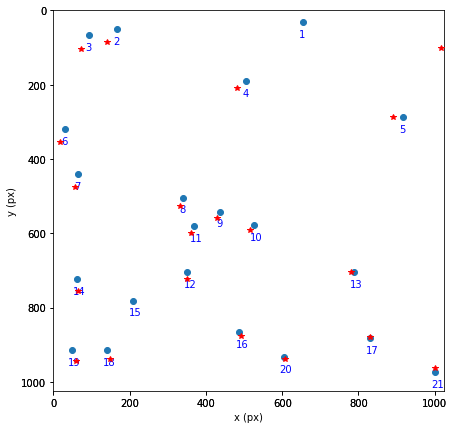

In [25]:
## Write code which produces a plot similar to fig4
## But, the key difference is, there will be only 1 x and 1 y axes.
## See visually that the stars are lining up

# Plotting the star position obtained from querying Vizier
# and plotting our obtained centroids on the same plot
fig4 = plt.figure(figsize = [7, 7])
axs = fig4.add_subplot(111, label='science', frame_on=True)
axq = fig4.add_subplot(111, label='Query'  , frame_on=False)

axs.scatter(np.squeeze(centroids_list[:,0:1]), np.squeeze(centroids_list[:,1:2]))
# axs.set_xlim(axs.get_xlim()[::-1])
axs.set_ylim(axs.get_ylim()[::-1])

axq.plot(smallx, smally, 'r*')
axq.set_ylim([0,1024])
axq.set_xlim([0,1024])
plt.gca().invert_yaxis()


# Adjust Axes limits of 'axq' so that the stars visually line up

for i, (loc_x, loc_y) in enumerate(centroids_list[:,0:2]):
    axs.text(loc_x-10, loc_y+40, str(i+1), color = 'blue')

axs.set_xlabel('x (px)')  
axs.set_ylabel('y (px)')
axs.set_xlim([0,1024])
axs.set_ylim([1024,0])

fig4.show()

*Remember to Save the notebook, then select **Kernel $\rightarrow$ Restart & Run All** before you submit*.

Make sure you have replaced all lines of code which read:

`# YOUR CODE HERE
raise NotImplementedError()`